Loading document data...
Loaded 15000 documents with 6 categories

Category distribution:
  - health: 2500 documents (16.7%)
  - environment: 2500 documents (16.7%)
  - technology: 2500 documents (16.7%)
  - economic: 2500 documents (16.7%)
  - sport: 2500 documents (16.7%)
  - politic: 2500 documents (16.7%)

Loading category-specific features...
  - economic: 7691 features loaded
  - environment: 8467 features loaded
  - health: 5715 features loaded
  - politic: 8253 features loaded
  - sport: 6079 features loaded
  - technology: 5782 features loaded

Splitting data into training and validation sets...
Training set: 10500 documents
Validation set: 4500 documents

Label mapping:
  0: economic
  1: environment
  2: health
  3: politic
  4: sport
  5: technology

Extracting features with top 100 features per category...
Total unique features selected: 562
Training features: (10500, 562)
Validation features: (4500, 562)

Extracting features with top 500 features per category...
Total uni

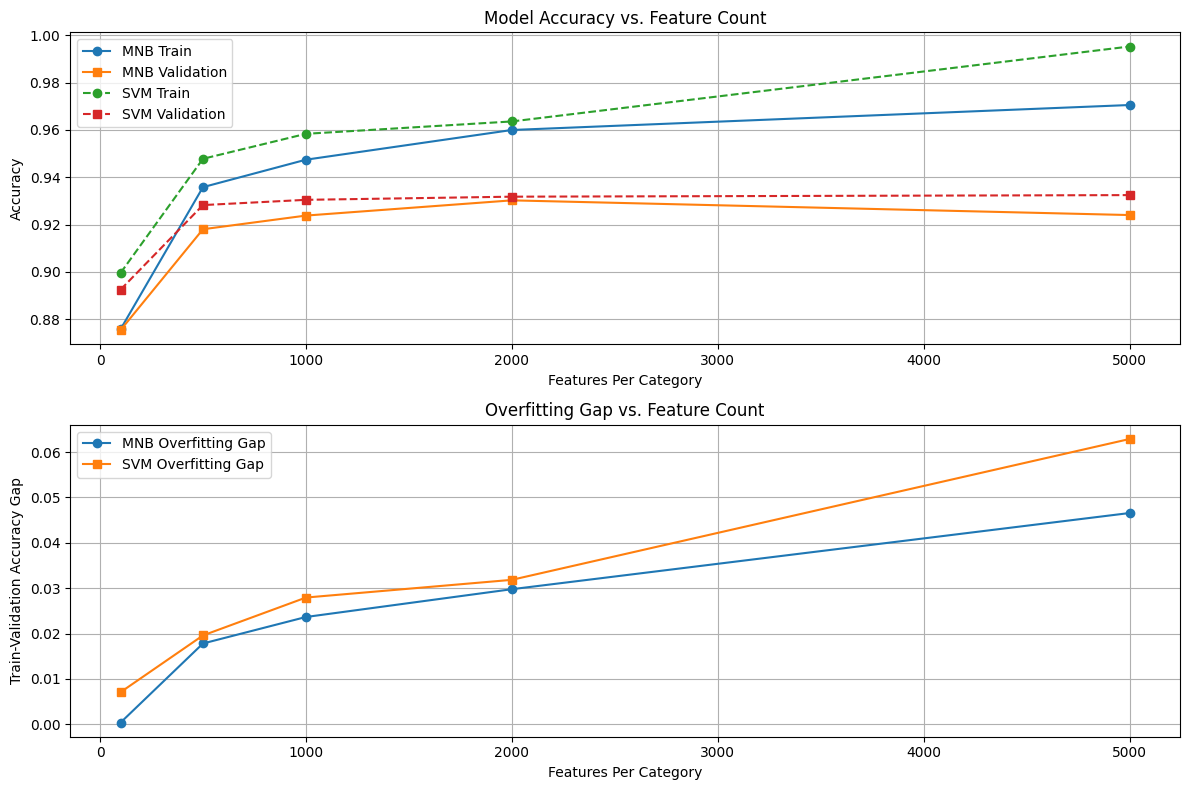


Best Feature Counts:
MNB - Best by validation accuracy: 2000 features per category
MNB - Best considering overfitting: 100 features per category
SVM - Best by validation accuracy: 5000 features per category
SVM - Best considering overfitting: 100 features per category

Best models and vectorizers saved to /Users/socheata/Documents/FYP-Khmer-Classification/Models

BEST MODEL COMPARISON

Accuracy Comparison:
MNB: 0.9302 (with 2000 features per category)
SVM: 0.9324 (with 5000 features per category)

Weighted Average Metrics Comparison:
Metric          MNB        SVM       
-----------------------------------
precision       0.9306    0.9324
recall          0.9302    0.9324
f1-score        0.9301    0.9323


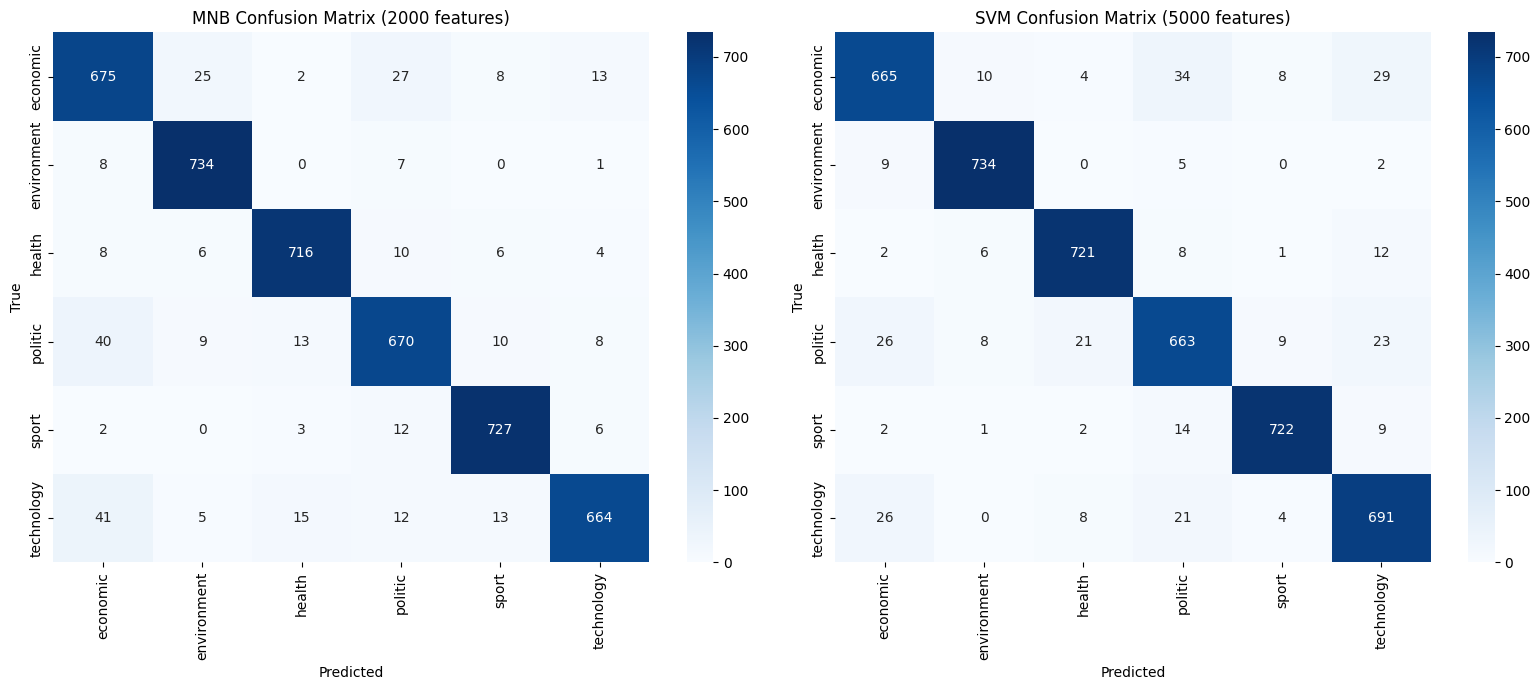

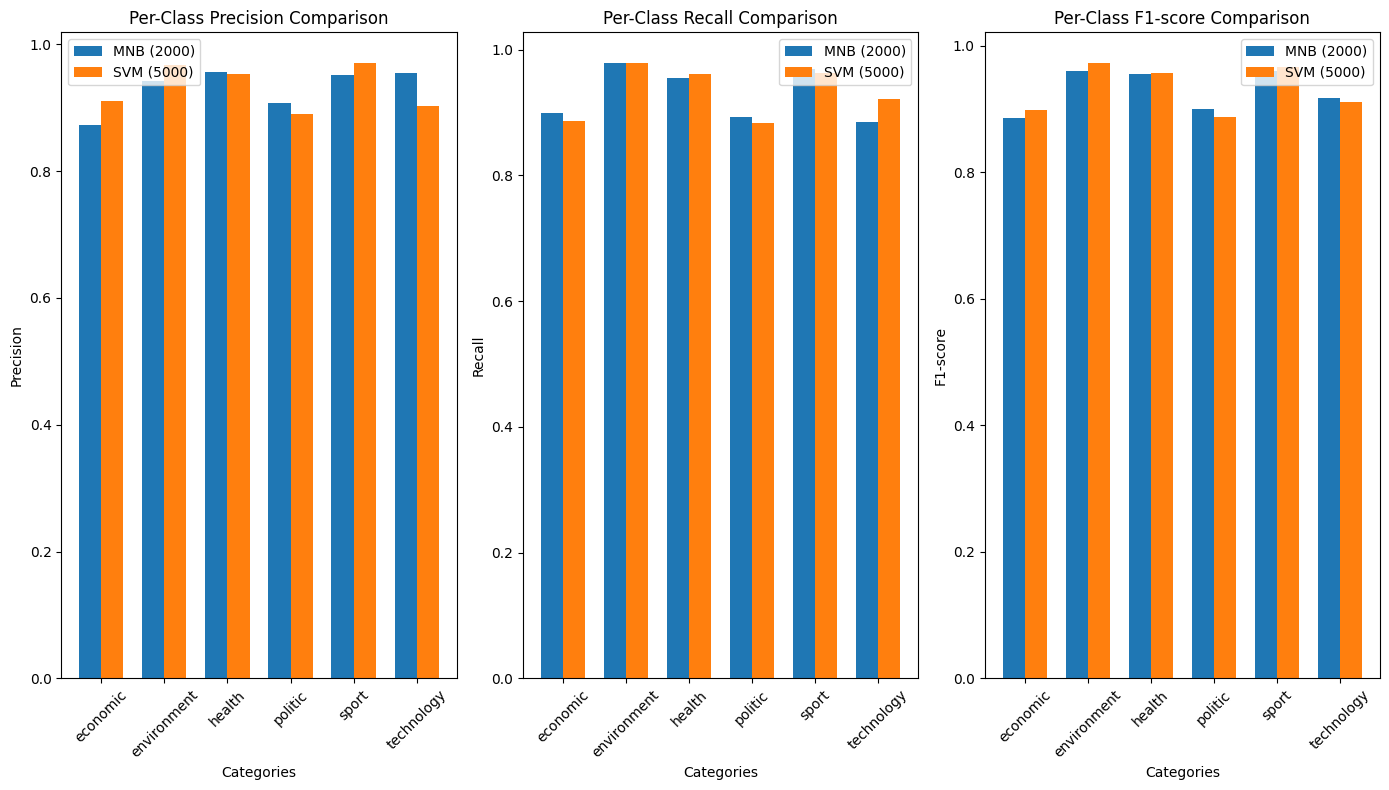


Plots saved to Models directory.

MODEL TRAINING AND EVALUATION COMPLETE


In [2]:
import os
import numpy as np
import pickle
import pandas as pd
import re
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
BASE_DIR = '/Users/socheata/Documents/FYP-Khmer-Classification'
FEATURE_DIR = os.path.join(BASE_DIR, 'TF_IDF_Features')
SELECTED_FEATURE_DIR = os.path.join(FEATURE_DIR, 'Selected_Features')
PROCESSED_TEXTS_DIR = os.path.join(BASE_DIR, 'Preprocess_articles')
METADATA_PATH = os.path.join(BASE_DIR, 'orginal_articles/metadata.csv')
MODEL_DIR = os.path.join(BASE_DIR, 'Models')
os.makedirs(MODEL_DIR, exist_ok=True)

# Define tokenizer
def tokenizer_split(text):
    """Simple tokenizer that splits on spaces (for preprocessed Khmer text)"""
    return text.split()

def load_data():
    """Load raw data and categories for processing"""
    print("Loading document data...")
    # Load metadata
    metadata_df = pd.read_csv(METADATA_PATH)
    doc_categories = dict(zip(metadata_df['docId'], metadata_df['category']))
    
    # Load all text files
    text_files = [f for f in os.listdir(PROCESSED_TEXTS_DIR) if f.endswith('.txt')]
    document_texts, document_categories, doc_ids = [], [], []
    
    for filename in text_files:
        doc_id = os.path.splitext(filename)[0]
        if doc_id not in doc_categories:
            continue
        with open(os.path.join(PROCESSED_TEXTS_DIR, filename), 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Replace double newlines with space (combine title and body)
        text = text.replace('\n\n', ' ')
        
        document_texts.append(text)
        document_categories.append(doc_categories[doc_id])
        doc_ids.append(doc_id)
    
    print(f"Loaded {len(document_texts)} documents with {len(set(document_categories))} categories")
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'id': doc_ids,
        'text': document_texts,
        'category': document_categories
    })
    
    # Print category distribution
    print("\nCategory distribution:")
    category_counts = df['category'].value_counts()
    for cat, count in category_counts.items():
        print(f"  - {cat}: {count} documents ({count/len(df)*100:.1f}%)")
    
    return df

def load_category_features():
    """Load the top features for each category from the Selected_Features directory"""
    print("\nLoading category-specific features...")
    
    # Define the categories based on the files in the directory
    categories = [
        "economic",
        "environment",
        "health",
        "politic",
        "sport",
        "technology"
    ]
    
    # Dictionary to hold features for each category
    category_features = {}
    
    for category in categories:
        feature_file = os.path.join(SELECTED_FEATURE_DIR, f"unique_features_{category}.txt")
        
        if not os.path.exists(feature_file):
            print(f"Warning: Feature file for {category} not found at {feature_file}")
            continue
        
        # Read features and scores
        features = []
        scores = []
        with open(feature_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    feature = parts[0]
                    score = float(parts[1])
                    features.append(feature)
                    scores.append(score)
        
        # Sort by score (highest first) in case they're not already sorted
        features_with_scores = sorted(zip(features, scores), key=lambda x: x[1], reverse=True)
        sorted_features = [f for f, s in features_with_scores]
        
        category_features[category] = sorted_features
        print(f"  - {category}: {len(sorted_features)} features loaded")
    
    return category_features, categories

def create_train_validation_split(df):
    """Split the data into training and validation sets"""
    print("\nSplitting data into training and validation sets...")
    
    # Split the data
    train_df, valid_df = train_test_split(
        df, 
        test_size=0.3, 
        random_state=42, 
        stratify=df['category']
    )
    
    print(f"Training set: {len(train_df)} documents")
    print(f"Validation set: {len(valid_df)} documents")
    
    # Create label encoder
    from sklearn import preprocessing
    encoder = preprocessing.LabelEncoder()
    encoder.fit(df['category'])
    
    # Encode labels
    y_train = encoder.transform(train_df['category'])
    y_valid = encoder.transform(valid_df['category'])
    
    # Print label mapping
    print("\nLabel mapping:")
    for i, category in enumerate(encoder.classes_):
        print(f"  {i}: {category}")
    
    return train_df, valid_df, y_train, y_valid, encoder

def extract_features_with_count(train_df, valid_df, category_features, feature_count_per_category):
    """Extract TF-IDF features using a specific number of top features per category"""
    print(f"\nExtracting features with top {feature_count_per_category} features per category...")
    
    # Collect the top N features from each category
    selected_features = set()
    for category, features in category_features.items():
        # Take the top N features or all if fewer are available
        top_n = min(feature_count_per_category, len(features))
        selected_features.update(features[:top_n])
    
    print(f"Total unique features selected: {len(selected_features)}")
    
    # Create TF-IDF vectorizer with the selected vocabulary
    vectorizer = TfidfVectorizer(
        tokenizer=tokenizer_split,  # Use simple space-based tokenization
        token_pattern=None,        # Disable default token pattern to use custom tokenizer
        encoding='utf-8',          # Ensure proper handling of UTF-8 (for Khmer)
        vocabulary=selected_features,  # Use only the selected features
        sublinear_tf=True           # Apply sublinear TF scaling
    )
    
    # Transform the training and validation sets
    X_train = vectorizer.fit_transform(train_df['text'])
    X_valid = vectorizer.transform(valid_df['text'])
    
    print(f"Training features: {X_train.shape}")
    print(f"Validation features: {X_valid.shape}")
    
    return X_train, X_valid, vectorizer

def train_and_evaluate_model(X_train, X_valid, y_train, y_valid, model_type='mnb', verbose=False):
    """Train and evaluate a model with the given feature matrices"""
    if model_type == 'mnb':
        # Train MultinomialNB with hyperparameter tuning
        best_alpha, best_accuracy = None, 0
        for alpha in [0.01, 0.1, 0.5, 1.0]:
            model = MultinomialNB(alpha=alpha)
            model.fit(X_train, y_train)
            accuracy = accuracy_score(y_valid, model.predict(X_valid))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_alpha = alpha
        
        if verbose:
            print(f"Best alpha for MNB: {best_alpha} with accuracy: {best_accuracy:.4f}")
        
        # Train with the best alpha
        model = MultinomialNB(alpha=best_alpha)
    else:  # model_type == 'svm'
        # Train LinearSVC with hyperparameter tuning
        best_c, best_accuracy = None, 0
        for c in [0.1, 1.0, 10.0]:
            model = LinearSVC(C=c, dual=False, max_iter=10000, random_state=42)
            model.fit(X_train, y_train)
            accuracy = accuracy_score(y_valid, model.predict(X_valid))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_c = c
        
        if verbose:
            print(f"Best C for SVM: {best_c} with accuracy: {best_accuracy:.4f}")
        
        # Train with the best C
        model = LinearSVC(C=best_c, dual=False, max_iter=10000, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate on both training and validation sets to check for overfitting
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    
    # Calculate classification reports
    train_report = classification_report(y_train, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
    valid_report = classification_report(y_valid, y_valid_pred, target_names=label_encoder.classes_, output_dict=True)
    
    # Generate confusion matrix for validation set
    cm = confusion_matrix(y_valid, y_valid_pred)
    
    return {
        'model': model,
        'train_accuracy': train_accuracy,
        'valid_accuracy': valid_accuracy,
        'train_report': train_report,
        'valid_report': valid_report,
        'confusion_matrix': cm,
        'overfitting_gap': train_accuracy - valid_accuracy
    }

def visualize_results(results):
    """Visualize the results for different feature counts"""
    feature_counts = list(results.keys())
    
    # Extract accuracies and overfitting gaps
    mnb_train_acc = [results[count]['mnb']['train_accuracy'] for count in feature_counts]
    mnb_valid_acc = [results[count]['mnb']['valid_accuracy'] for count in feature_counts]
    mnb_gap = [results[count]['mnb']['overfitting_gap'] for count in feature_counts]
    
    svm_train_acc = [results[count]['svm']['train_accuracy'] for count in feature_counts]
    svm_valid_acc = [results[count]['svm']['valid_accuracy'] for count in feature_counts]
    svm_gap = [results[count]['svm']['overfitting_gap'] for count in feature_counts]
    
    # Plot accuracy curves
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(feature_counts, mnb_train_acc, 'o-', label='MNB Train')
    plt.plot(feature_counts, mnb_valid_acc, 's-', label='MNB Validation')
    plt.plot(feature_counts, svm_train_acc, 'o--', label='SVM Train')
    plt.plot(feature_counts, svm_valid_acc, 's--', label='SVM Validation')
    plt.xlabel('Features Per Category')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy vs. Feature Count')
    plt.legend()
    plt.grid(True)
    
    # Plot overfitting gap
    plt.subplot(2, 1, 2)
    plt.plot(feature_counts, mnb_gap, 'o-', label='MNB Overfitting Gap')
    plt.plot(feature_counts, svm_gap, 's-', label='SVM Overfitting Gap')
    plt.xlabel('Features Per Category')
    plt.ylabel('Train-Validation Accuracy Gap')
    plt.title('Overfitting Gap vs. Feature Count')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'feature_count_comparison.png'))
    plt.show()
    
    # Find the best feature count for each model type
    best_mnb_count = max(feature_counts, key=lambda c: results[c]['mnb']['valid_accuracy'])
    best_svm_count = max(feature_counts, key=lambda c: results[c]['svm']['valid_accuracy'])
    
    # Consider overfitting - if gap is too large, prefer a smaller feature count
    max_acceptable_gap = 0.05  # 5% gap is acceptable
    
    for count in sorted(feature_counts):
        if results[count]['mnb']['overfitting_gap'] <= max_acceptable_gap:
            best_mnb_count_with_gap = count
            break
    else:
        best_mnb_count_with_gap = min(feature_counts, key=lambda c: results[c]['mnb']['overfitting_gap'])
    
    for count in sorted(feature_counts):
        if results[count]['svm']['overfitting_gap'] <= max_acceptable_gap:
            best_svm_count_with_gap = count
            break
    else:
        best_svm_count_with_gap = min(feature_counts, key=lambda c: results[c]['svm']['overfitting_gap'])
    
    print("\nBest Feature Counts:")
    print(f"MNB - Best by validation accuracy: {best_mnb_count} features per category")
    print(f"MNB - Best considering overfitting: {best_mnb_count_with_gap} features per category")
    print(f"SVM - Best by validation accuracy: {best_svm_count} features per category")
    print(f"SVM - Best considering overfitting: {best_svm_count_with_gap} features per category")
    
    # Save the best models
    with open(os.path.join(MODEL_DIR, f'mnb_model_{best_mnb_count}.pkl'), 'wb') as f:
        pickle.dump(results[best_mnb_count]['mnb']['model'], f)
    
    with open(os.path.join(MODEL_DIR, f'svm_model_{best_svm_count}.pkl'), 'wb') as f:
        pickle.dump(results[best_svm_count]['svm']['model'], f)
    
    # Save the vectorizer for the best feature counts
    with open(os.path.join(MODEL_DIR, f'vectorizer_{best_mnb_count}.pkl'), 'wb') as f:
        pickle.dump(results[best_mnb_count]['vectorizer'], f)
    
    with open(os.path.join(MODEL_DIR, f'vectorizer_{best_svm_count}.pkl'), 'wb') as f:
        pickle.dump(results[best_svm_count]['vectorizer'], f)
    
    print(f"\nBest models and vectorizers saved to {MODEL_DIR}")
    
    return best_mnb_count, best_svm_count

def analyze_best_models(results, best_mnb_count, best_svm_count):
    """Perform detailed analysis on the best models"""
    # Get the best models
    best_mnb = results[best_mnb_count]['mnb']
    best_svm = results[best_svm_count]['svm']
    
    print("\n" + "="*70)
    print("BEST MODEL COMPARISON")
    print("="*70)
    
    # Print accuracy comparison
    print("\nAccuracy Comparison:")
    print(f"MNB: {best_mnb['valid_accuracy']:.4f} (with {best_mnb_count} features per category)")
    print(f"SVM: {best_svm['valid_accuracy']:.4f} (with {best_svm_count} features per category)")
    
    # Print weighted average metrics
    print("\nWeighted Average Metrics Comparison:")
    mnb_weighted = best_mnb['valid_report']['weighted avg']
    svm_weighted = best_svm['valid_report']['weighted avg']
    
    metrics = ['precision', 'recall', 'f1-score']
    print(f"{'Metric':<15} {'MNB':<10} {'SVM':<10}")
    print("-"*35)
    for metric in metrics:
        print(f"{metric:<15} {mnb_weighted[metric]:.4f}    {svm_weighted[metric]:.4f}")
    
    # Plot confusion matrices
    class_names = label_encoder.classes_
    plt.figure(figsize=(16, 7))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(best_mnb['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'MNB Confusion Matrix ({best_mnb_count} features)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(best_svm['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'SVM Confusion Matrix ({best_svm_count} features)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'best_model_confusion_matrices.png'))
    plt.show()
    
    # Plot per-class metrics
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        mnb_scores = [best_mnb['valid_report'][cls][metric] for cls in class_names]
        svm_scores = [best_svm['valid_report'][cls][metric] for cls in class_names]
        
        x = np.arange(len(class_names))
        width = 0.35
        
        plt.bar(x - width/2, mnb_scores, width, label=f'MNB ({best_mnb_count})')
        plt.bar(x + width/2, svm_scores, width, label=f'SVM ({best_svm_count})')
        
        plt.xlabel('Categories')
        plt.ylabel(metric.capitalize())
        plt.title(f'Per-Class {metric.capitalize()} Comparison')
        plt.xticks(x, class_names, rotation=45)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'best_model_metrics_comparison.png'))
    plt.show()
    
    print("\nPlots saved to Models directory.")
    print("\nMODEL TRAINING AND EVALUATION COMPLETE")

# Main execution
if __name__ == "__main__":
    # Load data
    data_df = load_data()
    
    # Load category-specific features
    category_features, categories = load_category_features()
    
    # Create train/validation split
    train_df, valid_df, y_train, y_valid, label_encoder = create_train_validation_split(data_df)
    
    # Define the feature counts to test
    feature_counts_to_test = [100, 500, 1000, 2000, 5000]
    
    # Dictionary to store the feature matrices for each count
    feature_matrices = {}
    
    # Extract features for each count
    for count in feature_counts_to_test:
        X_train, X_valid, vectorizer = extract_features_with_count(train_df, valid_df, category_features, count)
        feature_matrices[count] = (X_train, X_valid, vectorizer)
    
    # Results dictionary to store all results
    results = {}
    
    # Train and evaluate both MNB and SVM for each feature count
    for count in feature_counts_to_test:
        X_train, X_valid, vectorizer = feature_matrices[count]
        print(f"\nTraining models with {count} features per category...")
        
        mnb_results = train_and_evaluate_model(X_train, X_valid, y_train, y_valid, model_type='mnb', verbose=True)
        svm_results = train_and_evaluate_model(X_train, X_valid, y_train, y_valid, model_type='svm', verbose=True)
        
        results[count] = {
            'mnb': mnb_results,
            'svm': svm_results,
            'feature_count': count,
            'vectorizer': vectorizer
        }
        
        print(f"MNB - Train: {mnb_results['train_accuracy']:.4f}, Valid: {mnb_results['valid_accuracy']:.4f}, Gap: {mnb_results['overfitting_gap']:.4f}")
        print(f"SVM - Train: {svm_results['train_accuracy']:.4f}, Valid: {svm_results['valid_accuracy']:.4f}, Gap: {svm_results['overfitting_gap']:.4f}")
    
    # Visualize the results
    best_mnb_count, best_svm_count = visualize_results(results)
    
    # Analyze the best models
    analyze_best_models(results, best_mnb_count, best_svm_count)